I am trying again to do this - with a slgihtly bigger meta learning rate (0.003 rather than 0.0005) to try and once I am getting this non-robust learning to go over the bridge rather than around the side, then I can confirm that PPO is working OK, and then I will feel comfortable uploading my updated MAML to the server and running it!

## Performing (non-robust) meta learning with the Khazad-Dum enviornment

In [1]:
#Perform imports
import random

import numpy as np
import torch
from torch import optim
from tqdm import tqdm

import gymnasium as gym


from stable_baselines3 import A2C,PPO

from stable_baselines3.common.logger import configure


import matplotlib.pyplot as plt


device = 'cpu'# 'cuda' #  #doing cpu as A2C with MlpPolicy (rather than CNNpolicy) in stablebaseline is faster on CPU, and the meta gradinet beign faster on GPU (even if it is) is not *that* much faster - it is about two(ish) times slower overall based on one run each with two meta iterations, so better on cpu in this case
torch.set_default_device(device)

In [2]:
model_save_path = "saved_models\\16May25_newMAMLtest2_PPO" #simulatenously testing my new maml syntax out and doing PPO (if somethings up, then try A2C with my new maml syntax to see if its my PPO that is wrong or the MAML syntax (too?))




In [3]:
import os
os.mkdir(model_save_path)

In [4]:
##Set up for meta learning

#Hyperparameters
adapt_lr =  7e-4
meta_lr = 0.003
meta_iterations = 100#500#1250
adapt_timesteps = 32*4 #for this enviornment, each episode is exactly 32 timesteps, so multiple of 32 means full number of eps experienced for each task
eval_timesteps = 100
tasks_per_loop = 40#60
adapt_visualisations = 15
M=1

vis_timesteps = meta_iterations//adapt_visualisations #denominator is number of visualisations we want
if vis_timesteps == 0:
    vis_timesteps = 1 

#Make meta-environment
import fabian.envs.khazad_dum_gymn 
env = gym.make("KhazadDum-v1") # can access wrapped env with "env.unwrapped" (e.g. to reset task)
env.unwrapped.exp_bonus = 1; env.unwrapped.bridge_bonus_factor = 2 #this should incentivise getting to the target asap, and incentivise going onto the bridge

#Make meta-policy and meta-optimiser
meta_agent = PPO("MlpPolicy", env, verbose=0, learning_rate=adapt_lr, device=device,
                 meta_learning=True, M=M, adapt_timesteps=adapt_timesteps, eval_timesteps=eval_timesteps) #we train the meta_agent to do well at adapting to new envs (i.e. meta learning) in our env distribution
meta_opt = optim.Adam(meta_agent.policy.parameters(), lr=meta_lr)

#Logging variables
meta_losses = []
meta_rets = []
best_meta_ret = None
best_meta_ret_it = -1

c:\Users\fabia\anaconda3\envs\projdist\Lib\site-packages\gymnasium\envs\registration.py:487: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(


In [5]:
#Quick sidebar looking into how PPO works
from stable_baselines3 import PPO
PPO_agent = PPO("MlpPolicy", env, verbose=0, learning_rate=adapt_lr, device=device,meta_learning=True, M=M, adapt_timesteps=adapt_timesteps, eval_timesteps=eval_timesteps)
PPO_agent.learn(total_timesteps = 32*8)
#yeah, PPO has a feature that it does several optimisation passes over each bit of data:
#https://deepwiki.com/DLR-RM/stable-baselines3/3.1-on-policy-algorithms

In [6]:
print(env)

<OrderEnforcing<PassiveEnvChecker<KhazadDum<KhazadDum-v1>>>>


In [7]:
print(meta_agent._wrap_env(env))

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\fabia\AppData\Local\Temp\ipykernel_50724\2167751684.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
  1%|          | 1/100 [05:05<8:23:16, 305.01s/it]

Meta loop 1/100 complete, validation loss: 0.054930079728364944, validation return: -0.16375932097434998


  7%|▋         | 7/100 [35:43<7:54:56, 306.42s/it]

Meta loop 7/100 complete, validation loss: 0.037959855049848557, validation return: -0.8766615986824036


 13%|█▎        | 13/100 [1:14:40<9:47:57, 405.49s/it]

Meta loop 13/100 complete, validation loss: 0.007164803333580494, validation return: -1.8588958978652954


 19%|█▉        | 19/100 [1:57:00<9:30:37, 422.68s/it]

Meta loop 19/100 complete, validation loss: -0.025150954723358154, validation return: -3.191472053527832


 25%|██▌       | 25/100 [2:39:28<8:53:43, 426.98s/it]

Meta loop 25/100 complete, validation loss: -0.05927811190485954, validation return: -3.51640248298645


 31%|███       | 31/100 [3:25:26<8:41:08, 453.17s/it]

Meta loop 31/100 complete, validation loss: -0.06661546975374222, validation return: -2.6932179927825928


 37%|███▋      | 37/100 [4:02:17<6:15:01, 357.17s/it]

Meta loop 37/100 complete, validation loss: 0.05532487481832504, validation return: -2.776022434234619


 43%|████▎     | 43/100 [4:42:16<6:40:01, 421.08s/it]

Meta loop 43/100 complete, validation loss: 0.04559729993343353, validation return: -3.6292457580566406


 49%|████▉     | 49/100 [5:26:00<6:12:16, 437.97s/it]

Meta loop 49/100 complete, validation loss: -0.06400507688522339, validation return: -4.411110877990723


 55%|█████▌    | 55/100 [6:10:20<5:29:55, 439.90s/it]

Meta loop 55/100 complete, validation loss: -0.09814183413982391, validation return: -4.245044231414795


 61%|██████    | 61/100 [6:45:38<3:45:31, 346.96s/it]

Meta loop 61/100 complete, validation loss: -0.02378084324300289, validation return: -3.0724151134490967


 67%|██████▋   | 67/100 [7:19:20<3:08:48, 343.28s/it]

Meta loop 67/100 complete, validation loss: -0.0034831285011023283, validation return: -2.566087484359741


 73%|███████▎  | 73/100 [7:51:45<2:23:53, 319.76s/it]

Meta loop 73/100 complete, validation loss: -0.0012426895555108786, validation return: -2.8870418071746826


 79%|███████▉  | 79/100 [8:22:35<1:48:44, 310.67s/it]

Meta loop 79/100 complete, validation loss: -0.000953753013163805, validation return: -3.302135944366455


 85%|████████▌ | 85/100 [8:53:25<1:17:28, 309.88s/it]

Meta loop 85/100 complete, validation loss: 0.0006150082917883992, validation return: -3.336418628692627


 91%|█████████ | 91/100 [9:24:21<46:37, 310.80s/it]  

Meta loop 91/100 complete, validation loss: -0.0018091900274157524, validation return: -3.1244804859161377


 97%|█████████▋| 97/100 [9:55:44<15:40, 313.60s/it]

Meta loop 97/100 complete, validation loss: 0.0002366480912314728, validation return: -3.020169734954834


100%|██████████| 100/100 [10:11:07<00:00, 366.67s/it]


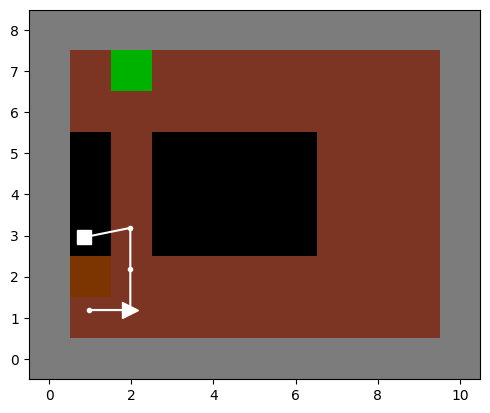

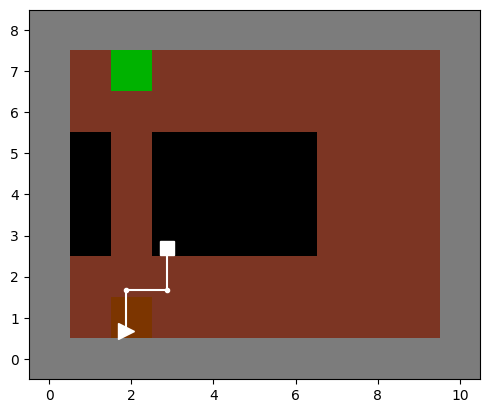

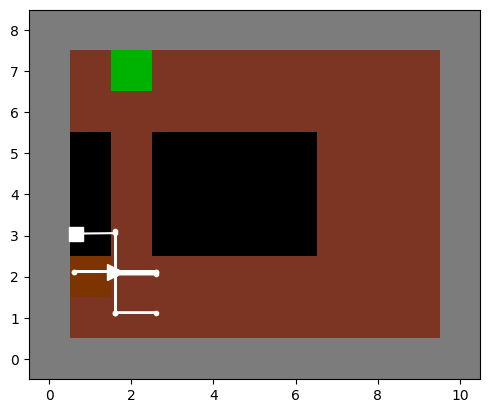

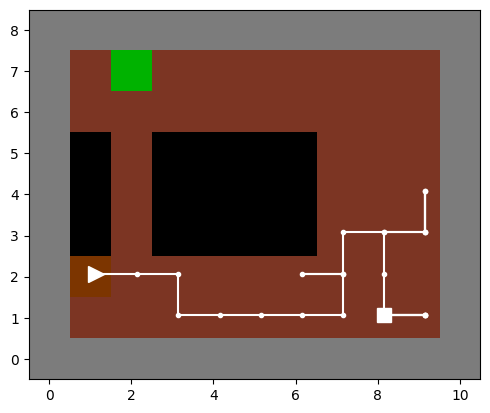

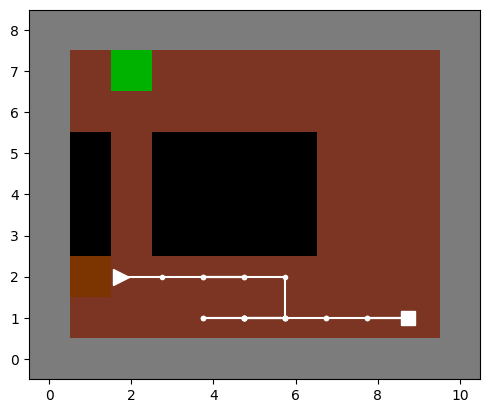

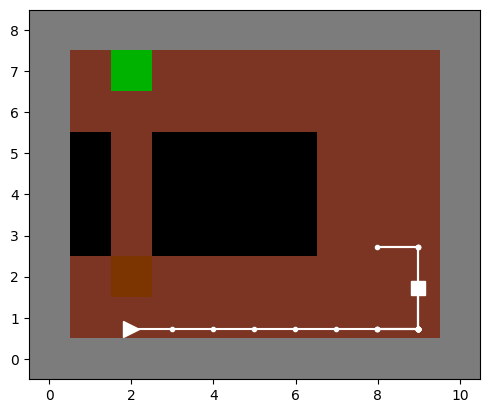

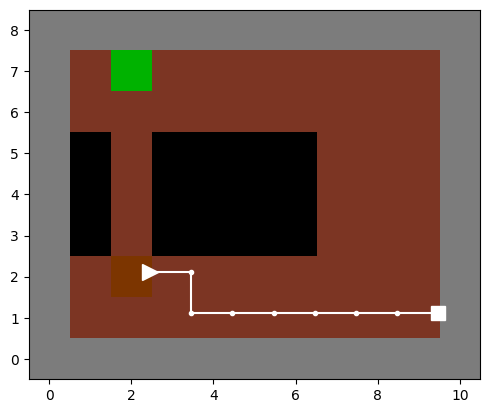

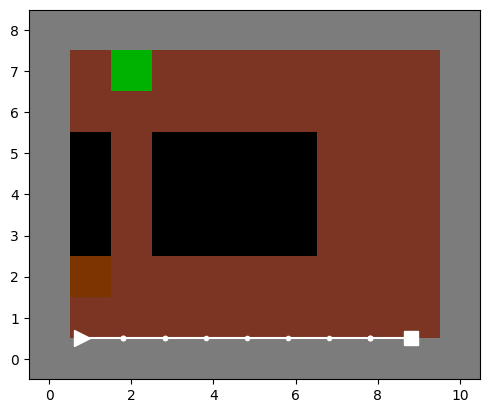

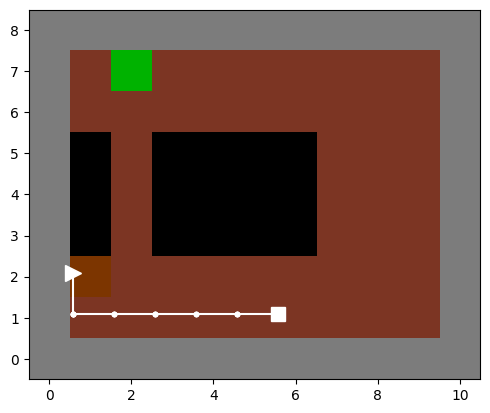

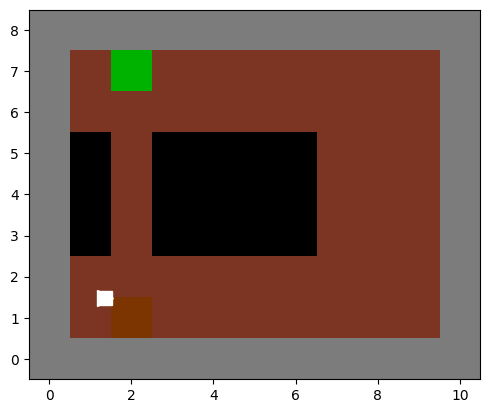

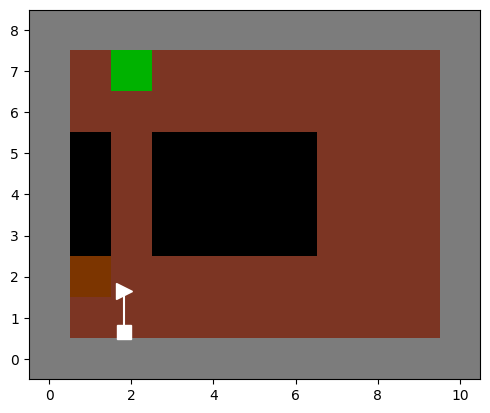

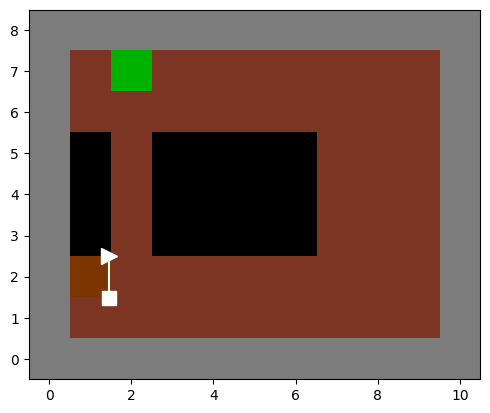

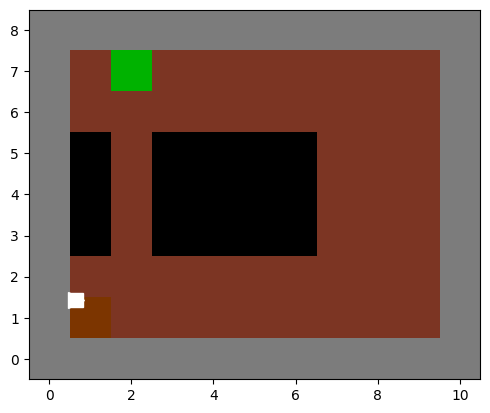

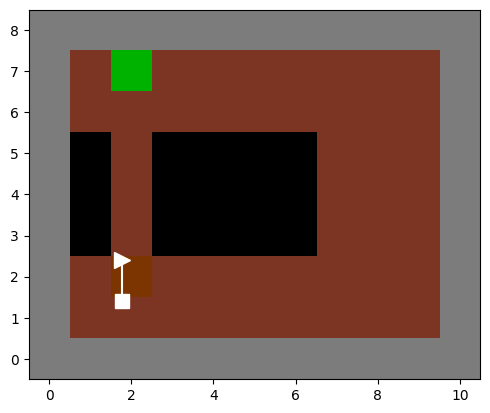

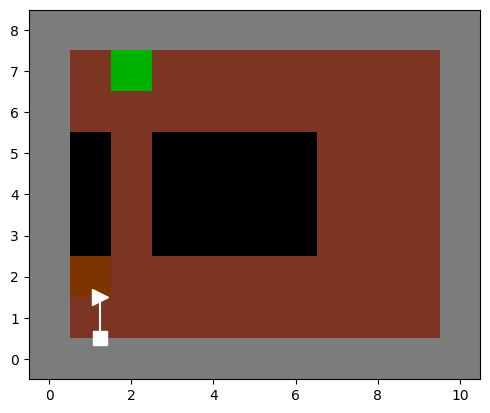

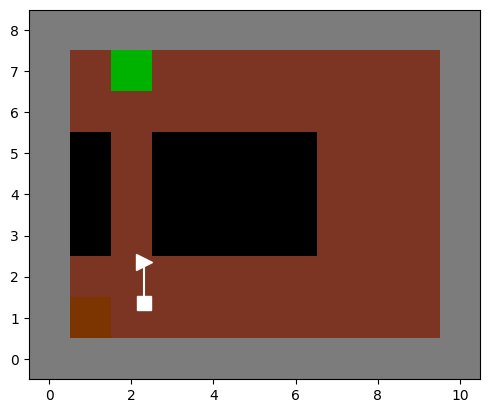

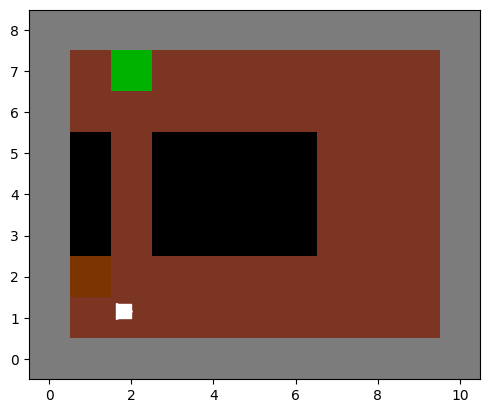

In [6]:
#Outer meta-learning loop
for meta_it in tqdm(range(meta_iterations)):
    meta_loss = 0
    meta_ret = 0
    #Have agent adapt to tasks one by one
    for t in (range(tasks_per_loop)):
        task_loss, task_return, _ = meta_agent.meta_adapt() #adapt to a randomly selected task {M} times
        meta_loss+=task_loss; meta_ret +=task_return

    #Perform gradient update on meta learning parameters
    meta_loss/=tasks_per_loop #normalise, so that learning rate need not depend on tasks/loop
    meta_ret/=tasks_per_loop
    
    meta_opt.zero_grad()
    meta_loss.backward()
    meta_opt.step()

    #Track meta_training curve
    meta_losses.append(meta_loss.detach().item())
    meta_rets.append(meta_ret.item())


    if meta_it % vis_timesteps == 0:
        #Output training info to console
        print(f"Meta loop {meta_it+1}/{meta_iterations} complete, validation loss: {meta_loss.detach().item()}, validation return: {meta_ret}")

        #Qualitative plot of adapted policy
        fig, ax = plt.subplots()
        ax = env.unwrapped.show_state(ax)    
        fig.show()

#TODO: note that the way I am doing MAML relies very much on the get_loss_rets function being right, as that loss is what I then adjust to optimise the model. It is also what is reported as the validation loss - if that is no good, then the model won't train right
#The fact that the validation loss is getting nicely lower but the return is not improving may be a bad sign, but we will have to see!

#Does doing awawy with the clipping cause me to lose something important, perhaps because the loss function may actually be super silly without clipping and so i screw it up? that doesnt really make sense as i am just using the normal loss function for evaluating
# a bunch of rollouts, it seems like the right function to use and then i am optimising the parameters of the policy?
# ^ the thing is, I dont necessarily just want the loss to be 'the thing i want' (i.e. a good final return) if that means we dont incentivise other things we know we need to get the thing I want (e.g. good value estimation)

#TODO: check that meta_agent.policy.parameters() are indeed the parameters i wanna be optimising in PPO, surely they are? If not maybe that is a function i should make in OPA class that is implemented by subclasses that just returns all the aprameters to be meta optimised?
# also maybe check online (even llms?) what may be going on and how to do meta learning with a PPO agent


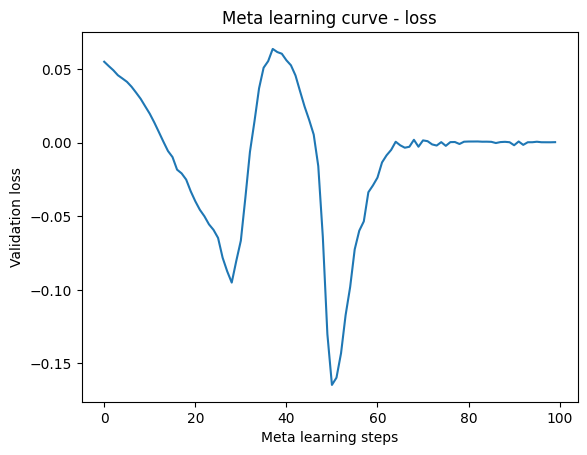

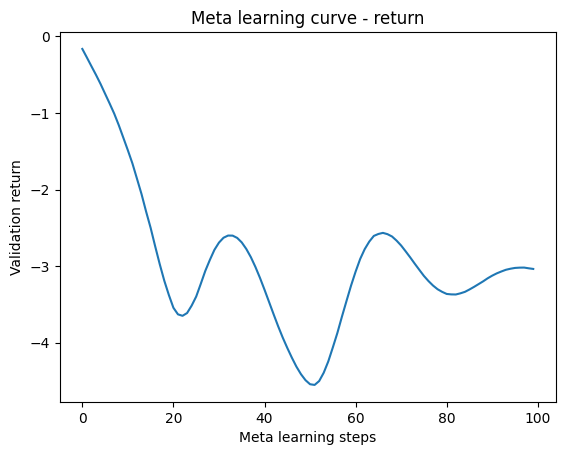

In [7]:
##Plot meta learning curves
xs = range(len(meta_losses))

plt.plot(xs, meta_losses)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation loss')
plt.title('Meta learning curve - loss')
plt.show()

plt.plot(xs, meta_rets)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation return')
plt.title('Meta learning curve - return')
plt.show()

In [8]:
torch.save(meta_agent.policy.state_dict(), f"{model_save_path}/final")

  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\fabia\AppData\Local\Temp\ipykernel_50724\2751038697.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
  3%|▎         | 1/30 [05:13<2:31:25, 313.28s/it]

Meta loop 1/30 complete, validation loss: 0.00018277035269420594, validation return: -3.049456834793091


 23%|██▎       | 7/30 [36:28<1:59:09, 310.84s/it]

Meta loop 7/30 complete, validation loss: 0.0001343341136816889, validation return: -3.1465165615081787


 43%|████▎     | 13/30 [1:07:56<1:29:07, 314.57s/it]

Meta loop 13/30 complete, validation loss: -0.001697984291240573, validation return: -3.1753673553466797


 63%|██████▎   | 19/30 [1:39:42<58:10, 317.35s/it]  

Meta loop 19/30 complete, validation loss: 4.541726229945198e-05, validation return: -3.1308484077453613


 83%|████████▎ | 25/30 [2:11:14<26:07, 313.44s/it]

Meta loop 25/30 complete, validation loss: -0.001372048631310463, validation return: -3.099822998046875


100%|██████████| 30/30 [2:37:26<00:00, 314.88s/it]


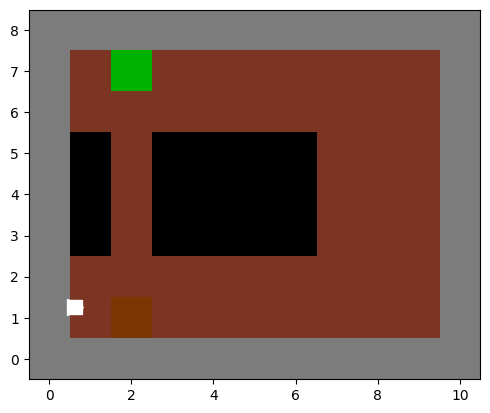

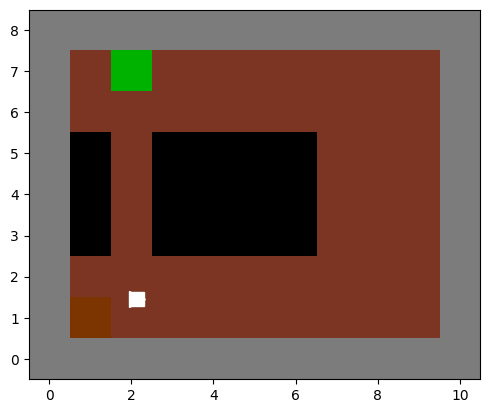

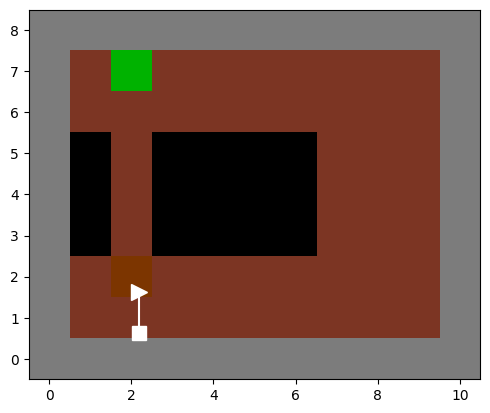

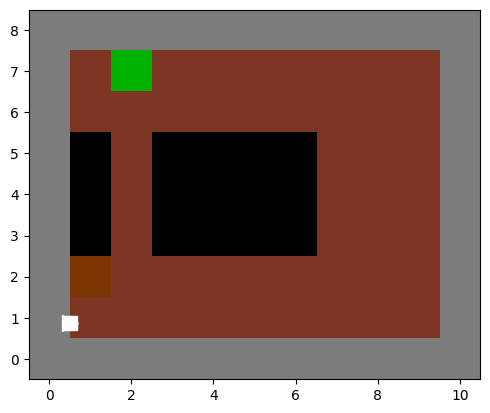

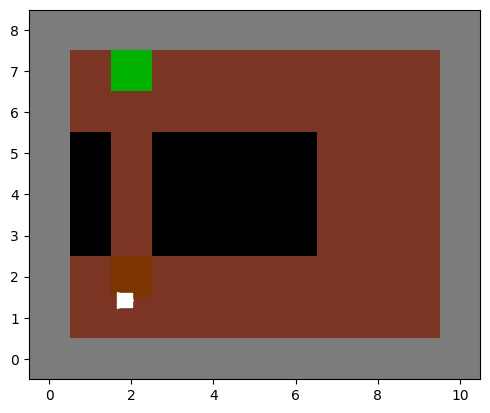

In [9]:
meta_iterations = 30

#Outer meta-learning loop
for meta_it in tqdm(range(meta_iterations)):
    meta_loss = 0
    meta_ret = 0
    #Have agent adapt to tasks one by one
    for t in (range(tasks_per_loop)):
        task_loss, task_return, _ = meta_agent.meta_adapt() #adapt to a randomly selected task {M} times
        meta_loss+=task_loss; meta_ret +=task_return

    #Perform gradient update on meta learning parameters
    meta_loss/=tasks_per_loop #normalise, so that learning rate need not depend on tasks/loop
    meta_ret/=tasks_per_loop
    
    meta_opt.zero_grad()
    meta_loss.backward()
    meta_opt.step()

    #Track meta_training curve
    meta_losses.append(meta_loss.detach().item())
    meta_rets.append(meta_ret.item())


    if meta_it % vis_timesteps == 0:
        #Output training info to console
        print(f"Meta loop {meta_it+1}/{meta_iterations} complete, validation loss: {meta_loss.detach().item()}, validation return: {meta_ret}")

        #Qualitative plot of adapted policy
        fig, ax = plt.subplots()
        ax = env.unwrapped.show_state(ax)    
        fig.show()

#TODO: note that the way I am doing MAML relies very much on the get_loss_rets function being right, as that loss is what I then adjust to optimise the model. It is also what is reported as the validation loss - if that is no good, then the model won't train right
#The fact that the validation loss is getting nicely lower but the return is not improving may be a bad sign, but we will have to see!

#Does doing awawy with the clipping cause me to lose something important, perhaps because the loss function may actually be super silly without clipping and so i screw it up? that doesnt really make sense as i am just using the normal loss function for evaluating
# a bunch of rollouts, it seems like the right function to use and then i am optimising the parameters of the policy?
# ^ the thing is, I dont necessarily just want the loss to be 'the thing i want' (i.e. a good final return) if that means we dont incentivise other things we know we need to get the thing I want (e.g. good value estimation)

#TODO: check that meta_agent.policy.parameters() are indeed the parameters i wanna be optimising in PPO, surely they are? If not maybe that is a function i should make in OPA class that is implemented by subclasses that just returns all the aprameters to be meta optimised?
# also maybe check online (even llms?) what may be going on and how to do meta learning with a PPO agent


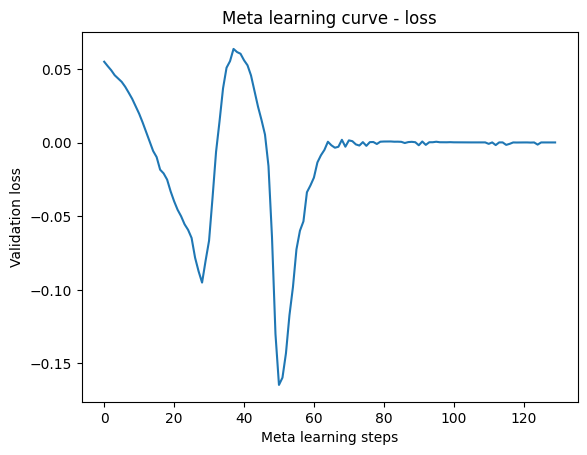

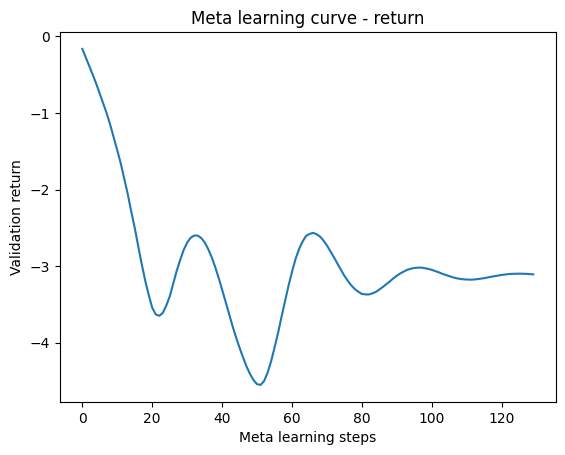

In [10]:
##Plot meta learning curves
xs = range(len(meta_losses))

plt.plot(xs, meta_losses)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation loss')
plt.title('Meta learning curve - loss')
plt.show()

plt.plot(xs, meta_rets)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation return')
plt.title('Meta learning curve - return')
plt.show()

In [11]:
torch.save(meta_agent.policy.state_dict(), f"{model_save_path}/final")

In [13]:
#Load in enviornemnt that performed best against meta validation
#loaded_meta_agent.policy.load_state_dict(torch.load(f"{model_save_path}\\best_val_meta_ret", weights_only=True)) 
    #as can be seen in the learning curve above, the model with the best meta-return is very much not the one which actually performs the best (if we see it perform, we see it just geniunely does badly!)
    #TODO: what is going on with that?

#loaded_meta_agent.policy.load_state_dict(torch.load(f"{model_save_path}\\meta_it_{495}", weights_only=True)) 

meta_agent.policy.load_state_dict(torch.load(f"{model_save_path}\\final", weights_only=True)) 


    #can also load in intermediate saved envs from training

<All keys matched successfully>

100%|██████████| 9/9 [01:11<00:00,  7.96s/it]
C:\Users\fabia\AppData\Local\Temp\ipykernel_50724\3705443118.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


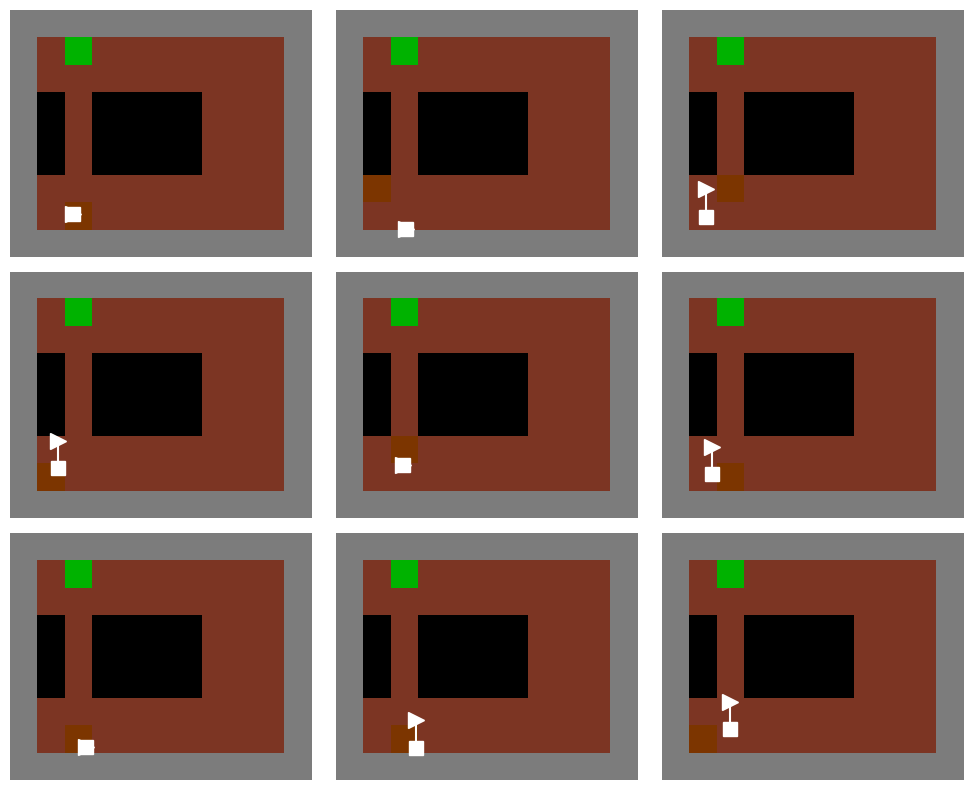

In [14]:
#Seeing it manage in a range of environments - this one is taken from loading the best model from a 400 meta-step training, which clearly isnt quite all that 
dim = 3
fig, axs = plt.subplots(dim, dim, figsize=(10, 8))

for t in tqdm(range(dim*dim)):
    #Perform few shot adaption to environment
    env.unwrapped.reset_task() #randomly selects task from environment to reset it to
    meta_agent.learn(total_timesteps=adapt_timesteps) #adapt the meta agent to this task

    #Test against a new trajectory from that state (else we are showing something it trained to and before the final training step)
    meta_agent.evaluate_policy(total_timesteps=32)

    #TODO: IMPROTANT TO NOTE - for fair evaluation of a MAML-meta-policy, as this is all about few-shot learning, we need to evaluate its performance to a task after having had a chance to adapt to that task

    #Plot this run
    x = t//dim
    y = t%dim
    axs[x,y] = env.unwrapped.show_state(axs[x,y])    
    axs[x,y].set_axis_off()
    
plt.tight_layout()

fig.show()


#TODO: i should do this again with a non meta-trained model that just learns for a single task and see how it does worse qualitatively